##### Imports the required libraries

In [1]:
""" Imports the required libraries """

# import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,  Activation, Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Flatten, Dropout, BatchNormalization, Reshape
from keras.utils.vis_utils import plot_model

import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Using TensorFlow backend.


##### Stores the path of the sensor files in the corresponding list

In [2]:
""" Stores the path of the sensor files in the corresponding list """

base_path = "./data/raw_data/"
phone_accel_file_paths = []
phone_gyro_file_paths = []
watch_accel_file_paths = []
watch_gyro_file_paths = []

for directories, subdirectories, files in os.walk(base_path):
    for filename in files:
        if "phone" in filename and "accel" in filename:
            phone_accel_file_paths.append(f"{base_path}phone/accel/{filename}")
        elif "phone" in filename and "gyro" in filename:
            phone_gyro_file_paths.append(f"{base_path}phone/gyro/{filename}")
        elif "watch" in filename and "accel" in filename:
            watch_accel_file_paths.append(f"{base_path}watch/accel/{filename}")
        elif "watch" in filename and "gyro" in filename:
            watch_gyro_file_paths.append(f"{base_path}watch/gyro/{filename}")

##### Stores the actual name of each activity in the dictionary

In [3]:
""" Stores the actual name of each activity in the dictionary """

activity_dict= {"A":"Walking",
                "B":"Jogging",
                "C":"Stairs",
                "D":"Sitting",
                "E":"Standing",
                "F":"Typing",
                "G":"Brushing",
                "H":"Eat Soup",
                "I":"Eat Chips",
                "J":"Eat Pasta",
                "K":"Drinking",
                "L":"Eat Sandwich",
                "M":"Kicking",
                "O":"Playing",
                "P":"Dribblinlg",
                "Q":"Writing",
                "R":"Clapping",
                "S":"Folding"}

##### Removes the columns "SubjectID" and "Timestamp" from the dataframe

In [4]:
def clean_data(dataframe):
    """ Removes the columns "SubjectID" and "Timestamp" from the dataframe """

    cleaned_df = dataframe.drop(["SubjectID", "Timestamp"], axis = 1).copy()

    return cleaned_df

##### Normalizes the data using StandardScaler() function

In [5]:
def scale_data(data):
    """ Normalizes the data using StandardScaler() function """
    
    le = LabelEncoder()
    data['ActivityCode'] = le.fit_transform(data['ActivityCode'])
    
    X = data[['X', 'Y', 'Z']]
    y = data['ActivityCode']
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    scaled_df = pd.DataFrame(data = X, columns = ['X', 'Y', 'Z'])
    scaled_df['ActivityCode'] = y.values
    
    return scaled_df

##### Decodes the activity labels and stores them in a dictionary

In [6]:
def activity_dictionary(dataframe):    
    """ Decodes the activity labels and stores them in the dictionary """

    activity_labels = dataframe["ActivityCode"]
    le = LabelEncoder()
    activity_indices = le.fit_transform(activity_labels)
    mapped_labels = dict(zip(le.transform(le.classes_), le.classes_))
    
    return mapped_labels

##### Preprocesses the data using clean() and scale() functions

In [7]:
def preprocess_data(dataframe):    
    """ Preprocesses the data using clean() and scale() functions """

    cleaned_df = clean_data(dataframe)
    
    return scale_data(cleaned_df)

##### Prints the cross validation report

In [8]:
def crossval_report(accuracy_per_fold, loss_per_fold):
    """ Prints the cross validation report """

    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(10):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {accuracy_per_fold[i]:.4f}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(accuracy_per_fold):.4f} (+- {np.std(accuracy_per_fold):.4f})')
    print(f'> Loss: {np.mean(loss_per_fold):.4f}')
    print('------------------------------------------------------------------------')

##### Plots training & validation accuracy values

In [9]:
def plot_learningCurve(history, epochs):
    """ Plots training & validation accuracy values """

    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history["val_accuracy"])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()
    
    """ Plots training & validation loss values """
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

##### Divides data into 2D frames
###### To write this code cell, we used part of this tutorial: https://www.youtube.com/watch?v=lUI6VMj43PE&t=2112s

In [10]:
""" Divides data into 2D frames """

frequency = 20 # Based on Hertz
time_period = 10 # Based on Second
frame_size = frequency * time_period
step_size = frame_size # In order not to have an overlap

def get_frames(df, frame_size, step_size):
    n_features = 3
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, step_size):
        x = df['X'].values[i: i + frame_size]
        y = df['Y'].values[i: i + frame_size]
        z = df['Z'].values[i: i + frame_size]
        
        label = stats.mode(df['ActivityCode'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    frames = np.asarray(frames).reshape(-1, frame_size, n_features)
    labels = np.asarray(labels)

    return frames, labels

##### Builds the model (the Convolutional Neural Network)

In [11]:
def get_model():
    """ Builds the model (the Convolutional Neural Network) """
    
    # Defines model
    model = Sequential()
    model.add(Conv2D(64, (2, 2), activation = 'relu', input_shape = inputs[0].shape))
#     model.add(Dropout(0.1))
#     model.add(Conv2D(64, (2, 2), activation='relu'))
#     model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(18, activation='softmax'))

    # Compiles model
    model.compile(optimizer=Adam(learning_rate = 0.001), 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

## Phone Accelerometer

In [13]:
""" Phone Accelerometer """

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

phone_accel_accuracy_per_fold = {}
phone_accel_loss_per_fold = {}

phone_accel_accuracy = {}
phone_accel_precision = {}
phone_accel_recall = {}
phone_accel_f1 = {}

phone_accel_matrix = {}
phone_accel_activity_accuracy = {}
phone_accel_classification_reports={}

fold_number = 1

for subjectid, file in enumerate(phone_accel_file_paths[:]):
    subjectid = file.split("_")[1]

    data = pd.read_csv(file, verbose=False)

    activity_labels = list(activity_dictionary(data).values())

    processed_data = preprocess_data(data)

    X, y = get_frames(processed_data, frame_size, step_size)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    # Makes the input data form 4-Dimensional
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 3, 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 3, 1)

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)

    acc_per_fold = []
    loss_per_fold = []    
    print("#########################################################################################")
    print(subjectid)
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        model = get_model()

        history = model.fit(inputs[train], targets[train], batch_size=128, epochs=70, validation_split=0.2, verbose=1)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        scores = model.evaluate(inputs[train], targets[train], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increases fold number
        fold_no = fold_no + 1

    phone_accel_accuracy_per_fold[subjectid] = acc_per_fold
    phone_accel_loss_per_fold[subjectid] = loss_per_fold

    y_true = targets[test]
    y_pred = model.predict_classes(inputs[test], verbose=0)

    # Accuracy: (tp + tn) / (p + n)
    phone_accel_accuracy[subjectid] = accuracy_score(y_true, y_pred)

    # Precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average=None, zero_division=1)
    phone_accel_precision[subjectid] = dict(zip(activity_labels, precision))

    # Recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average=None, zero_division=1)
    phone_accel_recall[subjectid] = dict(zip(activity_labels, recall))

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=1)
    phone_accel_f1[subjectid] = dict(zip(activity_labels, f1))    
    
#     phone_accel_classification_reports[subjectid] = classification_report(y_test, y_pred, zero_division=1)
    
#     matrix = confusion_matrix(y_test, y_pred)
#     phone_accel_matrix[subjectid] = matrix
    
#     accu_per_class = matrix.diagonal()/ matrix.sum(axis=1)
#     phone_accel_activity_accuracy[subjectid] = dict(zip(activity_labels, accu_per_class))

##### The cross validation report

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2271 - Accuracy: 93.7500%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2516 - Accuracy: 95.8477%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.1782 - Accuracy: 96.1938%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.1891 - Accuracy: 94.8097%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.2165 - Accuracy: 95.5017%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.2196 - Accuracy: 95.1557%
------------------------------------------------------------------------
> Fold 7 - Loss: 0.2086 - Accuracy: 96.5398%
------------------------------------------------------------------------
> Fold 8 - Lo

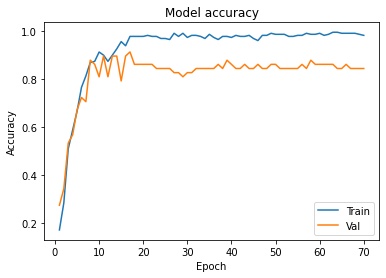

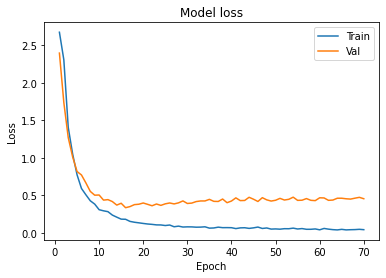

In [40]:
plot_learningCurve(history, 70)

### In order to prevent overfitting, we applied dropout (0.5) before the last layer of the network

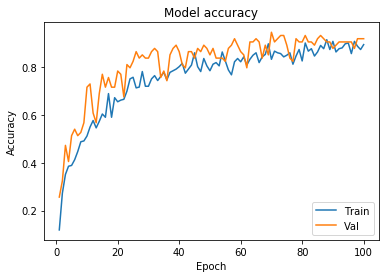

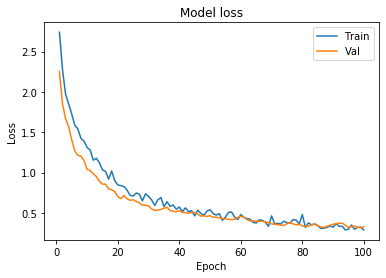

In [164]:
plot_learningCurve(history, 70)

## Phone Gyroscope

In [15]:
""" Phone Gyroscope """

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

phone_gyro_accuracy_per_fold = {}
phone_gyro_loss_per_fold = {}

phone_gyro_accuracy = {}
phone_gyro_precision = {}
phone_gyro_recall = {}
phone_gyro_f1 = {}

phone_gyro_matrix = {}
phone_gyro_activity_accuracy = {}
phone_gyro_classification_reports={}


fold_number = 1

for subjectid, file in enumerate(phone_gyro_file_paths[:]):
    subjectid = file.split("_")[1]

    data = pd.read_csv(file, verbose=False)

    activity_labels = list(activity_dictionary(data).values())

    processed_data = preprocess_data(data)

    X, y = get_frames(processed_data, frame_size, step_size)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    # Makes the input data form 4-Dimensional
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 3, 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 3, 1)

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)

    acc_per_fold = []
    loss_per_fold = []    
    print("#########################################################################################")
    print(subjectid)
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        model = get_model()

        history = model.fit(inputs[train], targets[train], batch_size=128, epochs=70, validation_split=0.2, verbose=1)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        scores = model.evaluate(inputs[train], targets[train], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increases fold number
        fold_no = fold_no + 1

    phone_gyro_accuracy_per_fold[subjectid] = acc_per_fold
    phone_gyro_loss_per_fold[subjectid] = loss_per_fold

    y_true = targets[test]
    y_pred = model.predict_classes(inputs[test], verbose=0)

    # Accuracy: (tp + tn) / (p + n)
    phone_gyro_accuracy[subjectid] = accuracy_score(y_true, y_pred)

    # Precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average=None, zero_division=1)
    phone_gyro_precision[subjectid] = dict(zip(activity_labels, precision))

    # Recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average=None, zero_division=1)
    phone_gyro_recall[subjectid] = dict(zip(activity_labels, recall))

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=1)
    phone_gyro_f1[subjectid] = dict(zip(activity_labels, f1))    
    
#     phone_gyro_classification_reports[subjectid] = classification_report(y_test, y_pred, zero_division=1)
    
#     matrix = confusion_matrix(y_test, y_pred)
#     phone_gyro_matrix[subjectid] = matrix
    
#     accu_per_class = matrix.diagonal()/ matrix.sum(axis=1)
#     phone_gyro_activity_accuracy[subjectid] = dict(zip(activity_labels, accu_per_class))

##### The cross validation report

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7301 - Accuracy: 88.1944%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9662 - Accuracy: 87.5433%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9321 - Accuracy: 85.4671%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9679 - Accuracy: 87.5433%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9317 - Accuracy: 87.8893%
------------------------------------------------------------------------
> Fold 6 - Loss: 1.1612 - Accuracy: 86.8512%
------------------------------------------------------------------------
> Fold 7 - Loss: 0.8738 - Accuracy: 87.5433%
------------------------------------------------------------------------
> Fold 8 - Lo

## Watch Accelerometer

In [17]:
# """ Watch Accelerometer """

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

watch_accel_accuracy_per_fold = {}
watch_accel_loss_per_fold = {}

watch_accel_accuracy = {}
watch_accel_precision = {}
watch_accel_recall = {}
watch_accel_f1 = {}

watch_accel_matrix = {}
watch_accel_activity_accuracy = {}
watch_accel_classification_reports={}

fold_number = 1

for subjectid, file in enumerate(watch_accel_file_paths[:]):
    subjectid = file.split("_")[1]

    data = pd.read_csv(file, verbose=False)

    activity_labels = list(activity_dictionary(data).values())

    processed_data = preprocess_data(data)

    X, y = get_frames(processed_data, frame_size, step_size)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    # Makes the input data form 4-Dimensional
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 3, 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 3, 1)

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)

    acc_per_fold = []
    loss_per_fold = []    
    print("#########################################################################################")
    print(subjectid)
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        model = get_model()

        history = model.fit(inputs[train], targets[train], batch_size=128, epochs=2, validation_split=0.2, verbose=1)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        scores = model.evaluate(inputs[train], targets[train], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increases fold number
        fold_no = fold_no + 1

    watch_accel_accuracy_per_fold[subjectid] = acc_per_fold
    watch_accel_loss_per_fold[subjectid] = loss_per_fold

    y_true = targets[test]
    y_pred = model.predict_classes(inputs[test], verbose=0)

    # Accuracy: (tp + tn) / (p + n)
    watch_accel_accuracy[subjectid] = accuracy_score(y_true, y_pred)

    # Precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average=None, zero_division=1)
    watch_accel_precision[subjectid] = dict(zip(activity_labels, precision))

    # Recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average=None, zero_division=1)
    watch_accel_recall[subjectid] = dict(zip(activity_labels, recall))

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=1)
    watch_accel_f1[subjectid] = dict(zip(activity_labels, f1))    
    
#     watch_accel_classification_reports[subjectid] = classification_report(y_test, y_pred, zero_division=1)
    
#     matrix = confusion_matrix(y_test, y_pred)
#     watch_accel_matrix[subjectid] = matrix
    
#     accu_per_class = matrix.diagonal()/ matrix.sum(axis=1)
#     watch_accel_activity_accuracy[subjectid] = dict(zip(activity_labels, accu_per_class))

##### The cross validation report

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2169 - Accuracy: 95.8730%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2066 - Accuracy: 94.9367%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.1725 - Accuracy: 95.2532%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.2720 - Accuracy: 94.3038%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.2252 - Accuracy: 94.6203%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.2351 - Accuracy: 93.0380%
------------------------------------------------------------------------
> Fold 7 - Loss: 0.2449 - Accuracy: 95.8861%
------------------------------------------------------------------------
> Fold 8 - Lo

## Watch Gyroscope

In [19]:
""" Watch Gyroscope """

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

watch_gyro_accuracy_per_fold = {}
watch_gyro_loss_per_fold = {}

watch_gyro_accuracy = {}
watch_gyro_precision = {}
watch_gyro_recall = {}
watch_gyro_f1 = {}

watch_gyro_matrix = {}
watch_gyro_activity_accuracy = {}
watch_gyro_classification_reports={}

fold_number = 1

for subjectid, file in enumerate(watch_gyro_file_paths[:]):
    subjectid = file.split("_")[1]

    data = pd.read_csv(file, verbose=False)

    activity_labels = list(activity_dictionary(data).values())

    processed_data = preprocess_data(data)

    X, y = get_frames(processed_data, frame_size, step_size)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    # Makes the input data form 4-Dimensional
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 3, 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 3, 1)

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)

    acc_per_fold = []
    loss_per_fold = []    
    print("#########################################################################################")
    print(subjectid)
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        model = get_model()

        history = model.fit(inputs[train], targets[train], batch_size=128, epochs=70, validation_split=0.2, verbose=1)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        scores = model.evaluate(inputs[train], targets[train], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increases fold number
        fold_no = fold_no + 1

    watch_gyro_accuracy_per_fold[subjectid] = acc_per_fold
    watch_gyro_loss_per_fold[subjectid] = loss_per_fold

    y_true = targets[test]
    y_pred = model.predict_classes(inputs[test], verbose=0)

    # Accuracy: (tp + tn) / (p + n)
    watch_gyro_accuracy[subjectid] = accuracy_score(y_true, y_pred)

    # Precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average=None, zero_division=1)
    watch_gyro_precision[subjectid] = dict(zip(activity_labels, precision))

    # Recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average=None, zero_division=1)
    watch_gyro_recall[subjectid] = dict(zip(activity_labels, recall))

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=1)
    watch_gyro_f1[subjectid] = dict(zip(activity_labels, f1))   
    
#     watch_gyro_classification_reports[subjectid] = classification_report(y_test, y_pred, zero_division=1)
    
#     matrix = confusion_matrix(y_test, y_pred)
#     watch_gyro_matrix[subjectid] = matrix
    
#     accu_per_class = matrix.diagonal()/ matrix.sum(axis=1)
#     watch_gyro_activity_accuracy[subjectid] = dict(zip(activity_labels, accu_per_class))

##### The cross validation report

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4807 - Accuracy: 89.8413%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.3752 - Accuracy: 91.4557%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5942 - Accuracy: 90.8228%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6152 - Accuracy: 90.1899%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5313 - Accuracy: 91.1392%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.5823 - Accuracy: 89.2405%
------------------------------------------------------------------------
> Fold 7 - Loss: 0.4954 - Accuracy: 90.1899%
------------------------------------------------------------------------
> Fold 8 - Lo

##### Accuracy obtained using different values of learning rate

In [424]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e1, 1.0, 10.0]
accuracies = [79.93, 95.96, 85.9, 30.10, 10.53, 5.88]
data = {'Learning Rate': learning_rates, 'Accuracy': accuracies}
df = pd.DataFrame(data=data)
df.set_index('Learning Rate', inplace=True)
df.transpose()

Learning Rate,0.0001,0.0010,0.0100,10.0000,1.0000,10.0000
Accuracy,79.93,95.96,85.9,30.1,10.53,5.88


##### Plots training accuracy values w.r.t learning rate

In [108]:
def plot_learningCurve():
    """ Plots training accuracy values w.r.t learning rate """
    
    x = [-4, -3, -2, -1, 0, 1]
    y = [79.93, 95.96, 85.9, 30.10, 10.53, 5.98]
    
    plt.plot(x, y, color='green', lw=2, linestyle='--', marker='D', markerfacecolor='red', markeredgecolor='red', markersize=5)
    plt.title('Model accuracy w.r.t learning rate', fontweight='bold', fontsize=15)
    plt.xlabel("Learning Rate (10^)", fontsize=13)
    plt.ylabel("Accuracy (%)", fontsize=13)
    plt.grid(color='b', linestyle='--', linewidth=0.5)
#     plt.xticks([0.1, 0.01, 0.001, 0.0001])
    plt.yticks(y)
#     plt.xlim(1.5, 12.5)
    plt.ylim(0, 100)
    plt.show()

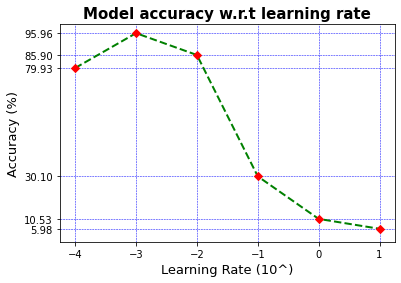

In [110]:
plot_learningCurve()

In [15]:
activity_dict= {0:"Walking",
                1:"Jogging",
                2:"Stairs",
                3:"Sitting",
                4:"Standing",
                5:"Typing",
                6:"Brushing Teeth",
                7:"Eating Soup",
                8:"Eating Chips",
                9:"Eating Pasta",
                10:"Drinking from Cup",
                11:"Eating Sandwich",
                12:"Kicking",
                13:"Playing Catch",
                14:"Dribblinlg Basketball",
                15:"Writing",
                16:"Clapping",
                17:"Folding Clothes"}

##### Plots the confusion Matrix

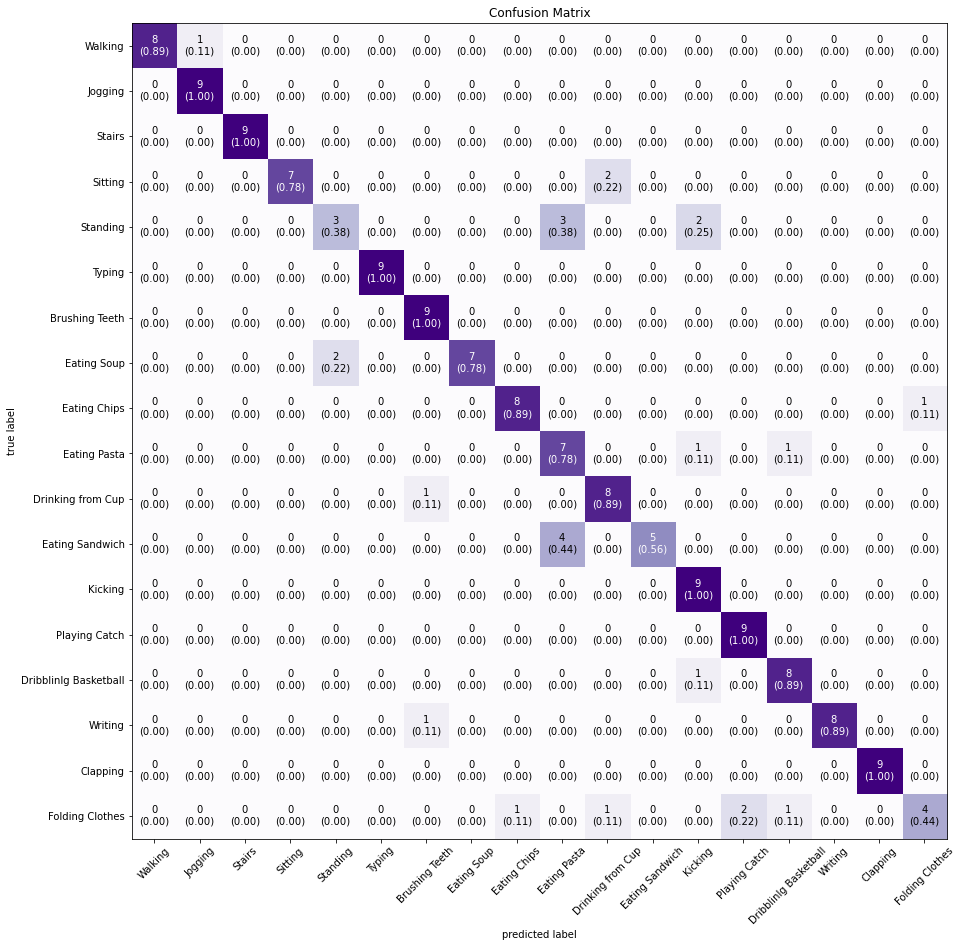

In [88]:
y_pred = model.predict_classes(X_test)
matrix = confusion_matrix(y_test, y_pred)
matrix_plot = plot_confusion_matrix(conf_mat=matrix, class_names=activity_dict.values(), show_normed=True, figsize=(15,15), cmap=plt.cm.Purples);
plt.title('Confusion Matrix')
plt.show()